In [1]:
#! pip install git+https://github.com/monolok/bertinizer.git --upgrade

In [2]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
#from bertinizer import plot_data, analyze_correlation, find_outliers

In [3]:
df = pd.read_csv('/Users/antoinebertin/Documents/jedha/full_stack/projects_full_stack/north_face/sample-data.csv')
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

# preprocessings corpus: stop words, lemmatize and clean text with regex

In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Function to preprocess text
def preprocess_text(doc):
    # Lemmatize and remove stop words
    return " ".join([token.lemma_ for token in nlp(doc) if token.text.lower() not in STOP_WORDS])

# Function to clean text data and remove short words
def clean_text(text):
    # Keep only alphabetic characters, effectively removing all non-alphabetic chars
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Remove words that are less than 3 characters long
    text = ' '.join([word for word in text.split() if len(word) > 2])
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip().lower()


In [6]:
# Preprocess descriptions
df['processed_description'] = df['description'].apply(preprocess_text)

In [7]:
# Example usage with your DataFrame
df['cleaned_description'] = df['processed_description'].apply(clean_text)

In [8]:
df.drop(['description', 'processed_description'], axis=1, inplace=True)

In [9]:
df

id                                cleaned_description
0      1  active classic boxer reason boxer cult favorit...
1      2  active sport boxer brief skin glory require mo...
2      3  active sport brief superbreathable fly brief m...
3      4  alpine guide pant skin climb ice switch rock t...
4      5  alpine wind jkt high ridge steep ice alpine ja...
..   ...                                                ...
495  496  cap bottom cut loose madden crowd search undon...
496  497  cap crew crew take edge fickle weather clearin...
497  498  time shell need use morning times umbrella tim...
498  499  wear cargo short wear cargo shorts bask glory ...
499  500  wear short time simplify wear short prove shor...

[500 rows x 2 columns]

# TF-IDF Transformation

In [10]:
df.head()

id                                cleaned_description
0   1  active classic boxer reason boxer cult favorit...
1   2  active sport boxer brief skin glory require mo...
2   3  active sport brief superbreathable fly brief m...
3   4  alpine guide pant skin climb ice switch rock t...
4   5  alpine wind jkt high ridge steep ice alpine ja...

In [11]:
#Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer() #TfidfVectorizer(stop_words='english')

#Fit and transform the processed descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_description'])

In [12]:
feature_names = tfidf_vectorizer.get_feature_names_out()
word_index = 0  # First row
indexes_of_first_row = tfidf_matrix[word_index].indices  # Indexes of words located in the first row
scores_of_first_row = tfidf_matrix[word_index].data  # TF-IDF scores of words in the first row

# Get list of (score, word) tuples
score_word = [(scores_of_first_row[idx], feature_names[word_idx]) 
              for idx, word_idx in enumerate(indexes_of_first_row)]
# Sort list by score in descending order 
score_word.sort(key=lambda x: x[0], reverse=True) 
print(score_word)

[(0.5409000947574236, 'boxer'), (0.26276502667823287, 'expose'), (0.2247693325742051, 'traditional'), (0.17587111738970443, 'classic'), (0.16261010622572866, 'especially'), (0.16261010622572866, 'reason'), (0.1525030870655636, 'situation'), (0.1525030870655636, 'cult'), (0.15243957868938032, 'panel'), (0.15243957868938032, 'brush'), (0.15166663370719474, 'construction'), (0.13976974882347531, 'underwear'), (0.1354430407490441, 'waistband'), (0.1327475760573213, 'quick'), (0.1306914515534376, 'size'), (0.12823509500687064, 'inseam'), (0.1224916854472676, 'take'), (0.12011589084946438, 'functional'), (0.11794696031314819, 'sticky'), (0.11410444996290876, 'favorite'), (0.11077591609710558, 'ultralight'), (0.11077591609710558, 'space'), (0.10649220880712171, 'minimal'), (0.10399743080274368, 'silky'), (0.10286438381257262, 'recycle'), (0.09867367425585072, 'mexico'), (0.09773292199281804, 'active'), (0.09682638658670105, 'travel'), (0.09613532480102219, 'dry'), (0.08987890419520086, 'gladi

# DBSCAN

In [13]:
# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

In [14]:
# DBSCAN clustering
#! metric='cosine'

# DBSCAN expects distances, so now that we've inverted our matrix, smaller eps values make more sense
dbscan = DBSCAN(eps=0.14, min_samples=4, metric='cosine')
clusters = dbscan.fit_predict(cosine_sim_matrix)
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21])

In [15]:
# Add cluster labels to the DataFrame
df['cluster'] = clusters
df['cluster'].value_counts()

cluster
-1     124
 1     106
 3      62
 0      39
 5      25
 2      22
 15     16
 9      15
 12     15
 8       8
 11      7
 16      7
 19      7
 10      6
 7       5
 20      5
 18      5
 13      5
 14      5
 6       4
 4       4
 17      4
 21      4
Name: count, dtype: int64

# word clouds

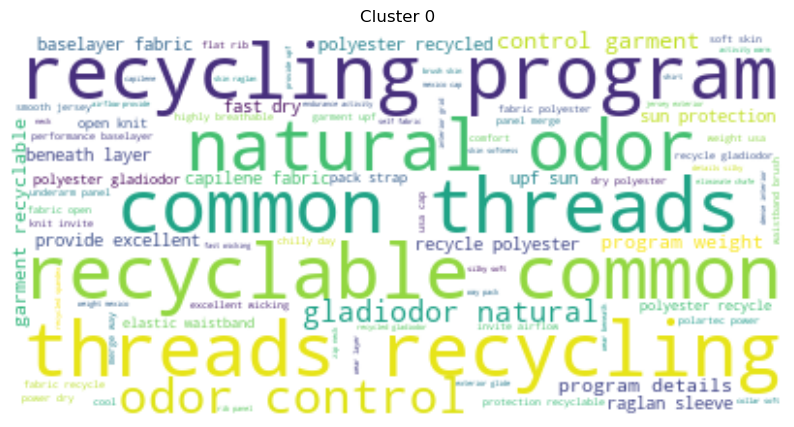

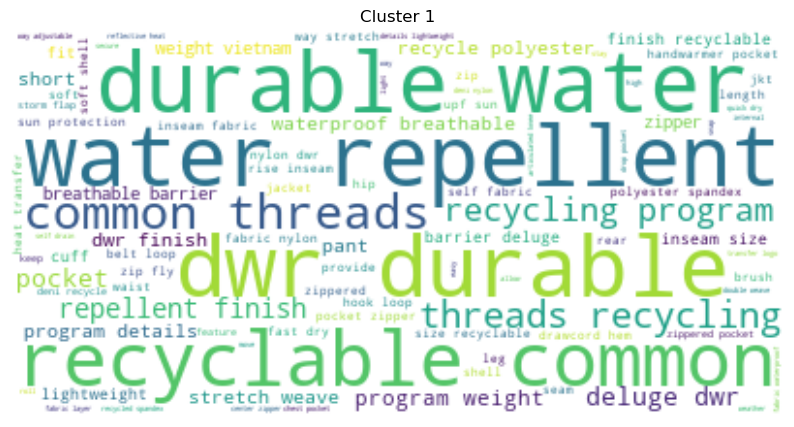

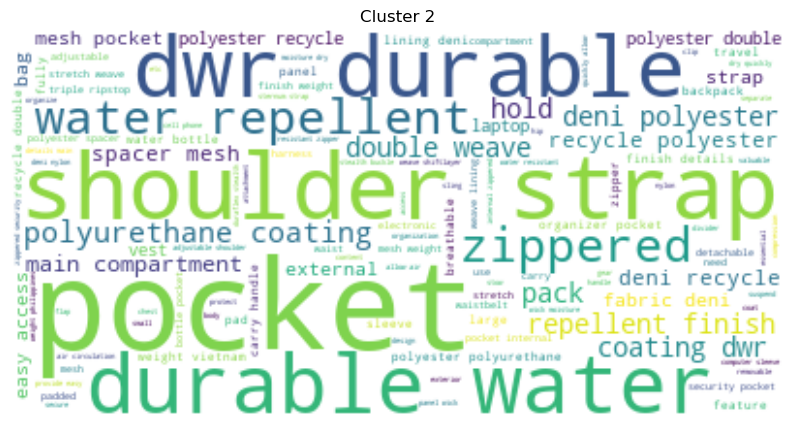

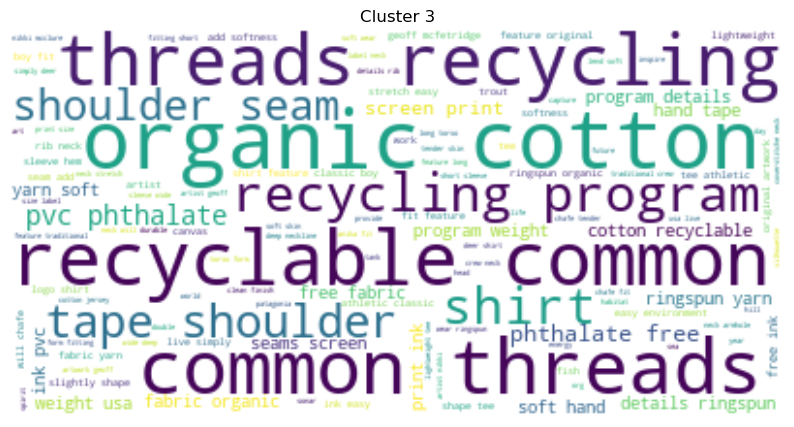

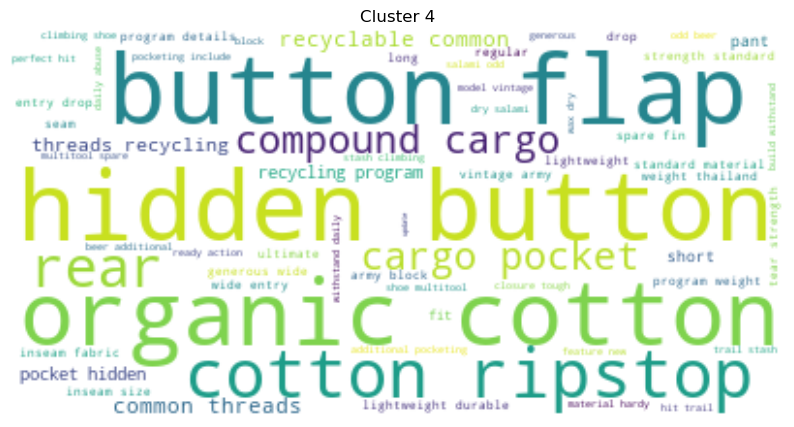

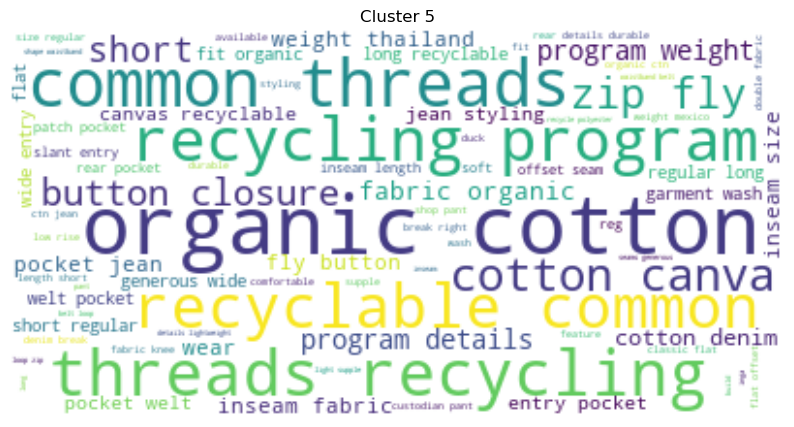

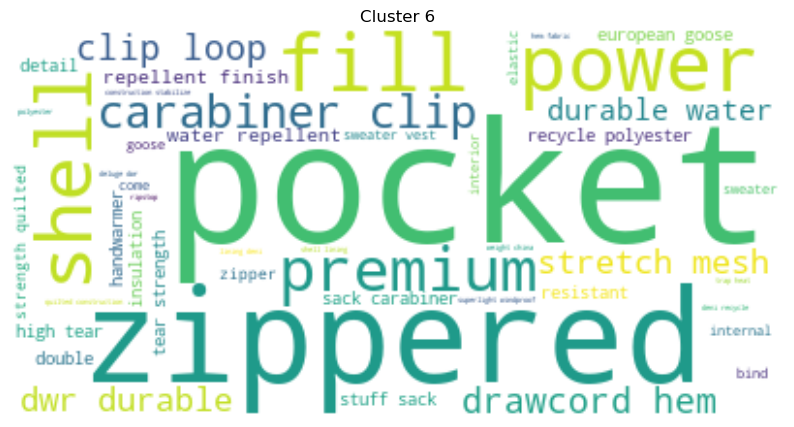

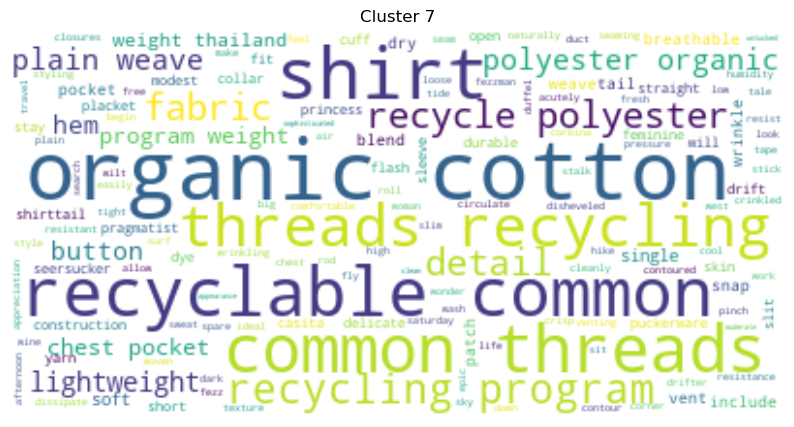

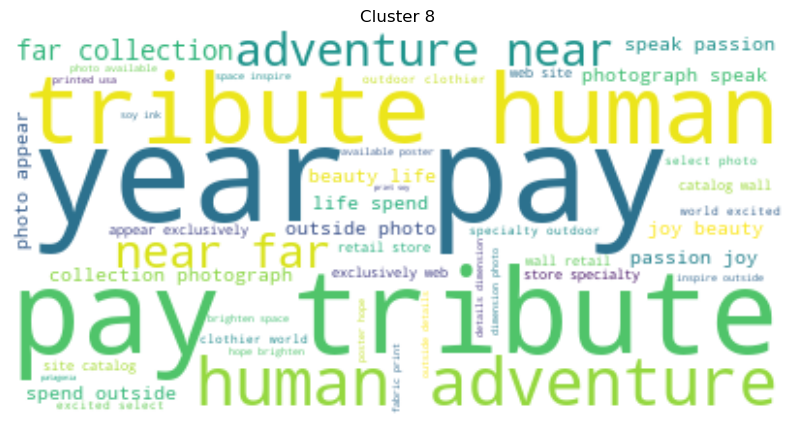

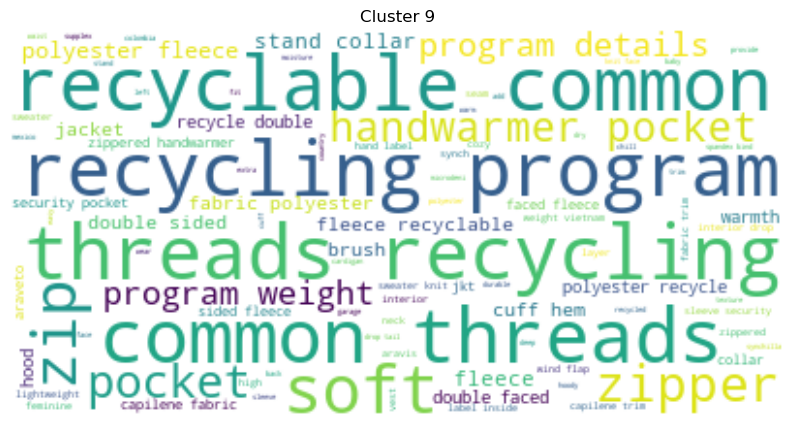

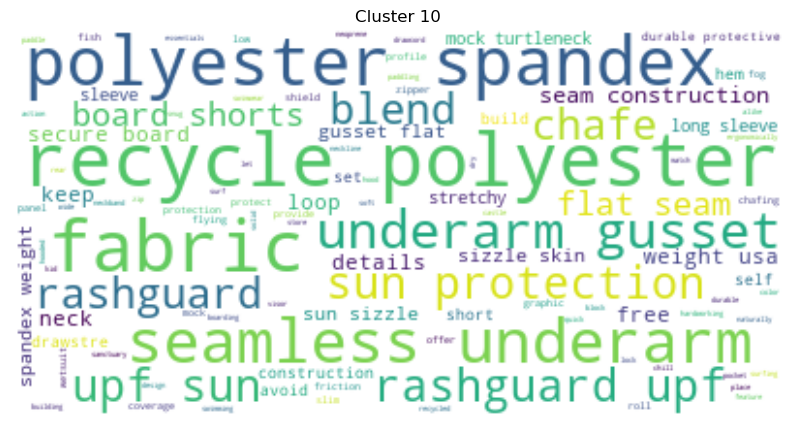

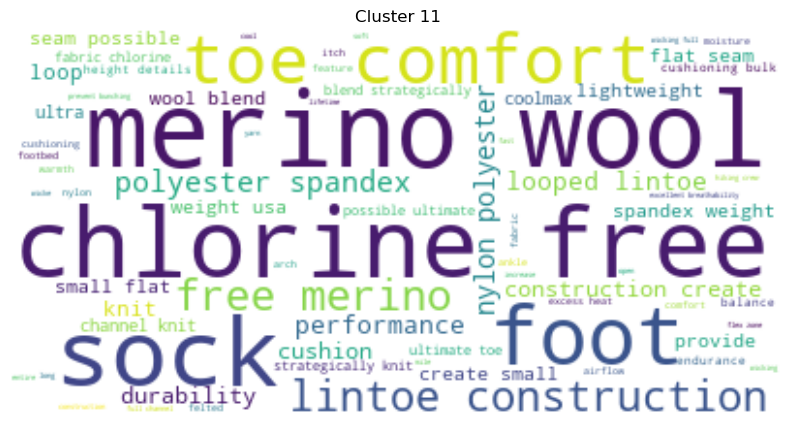

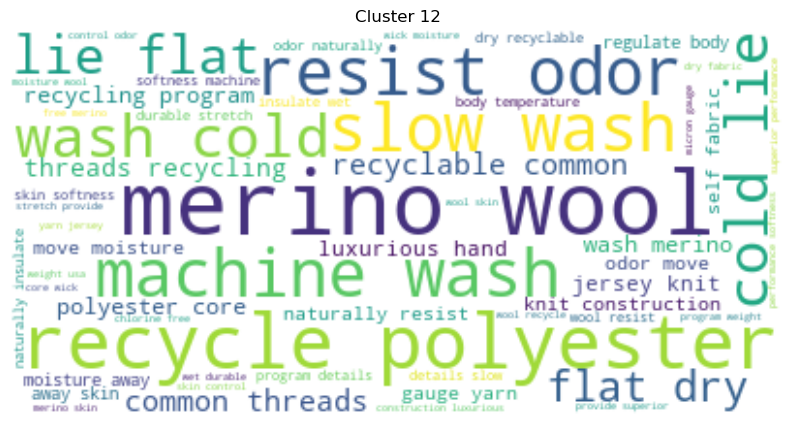

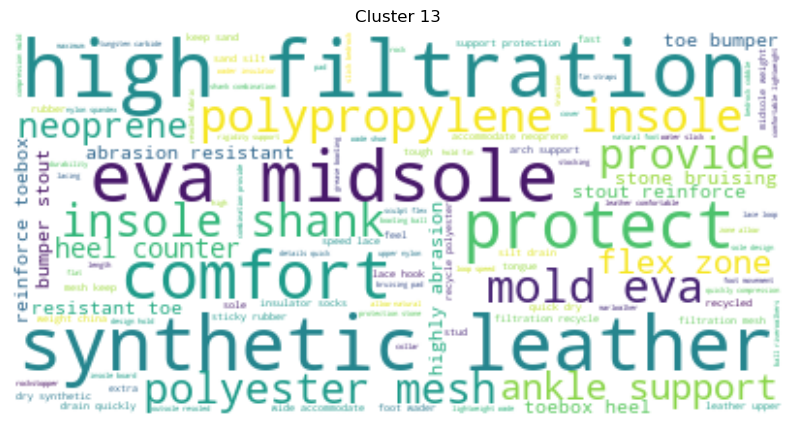

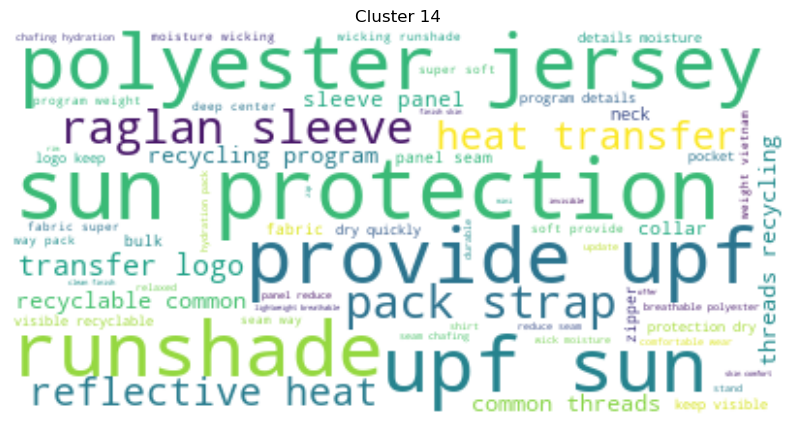

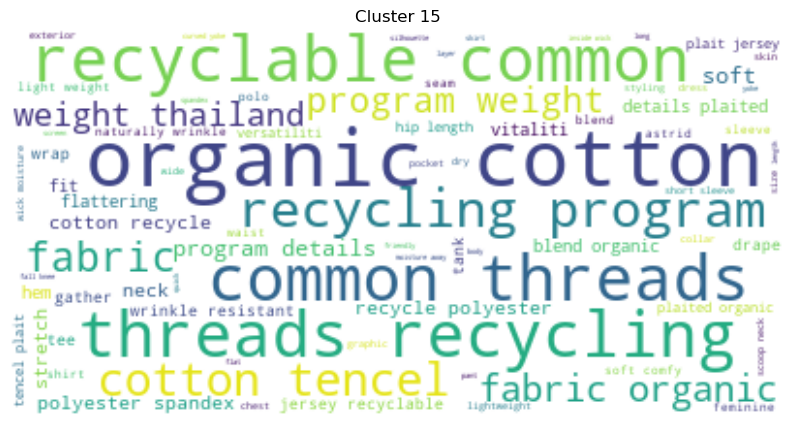

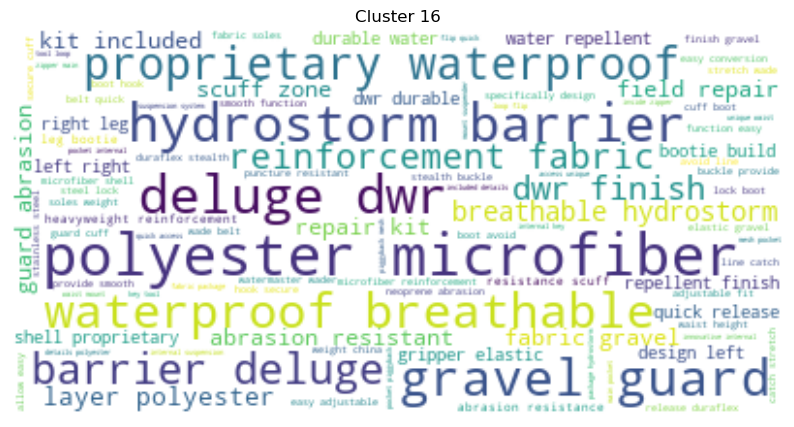

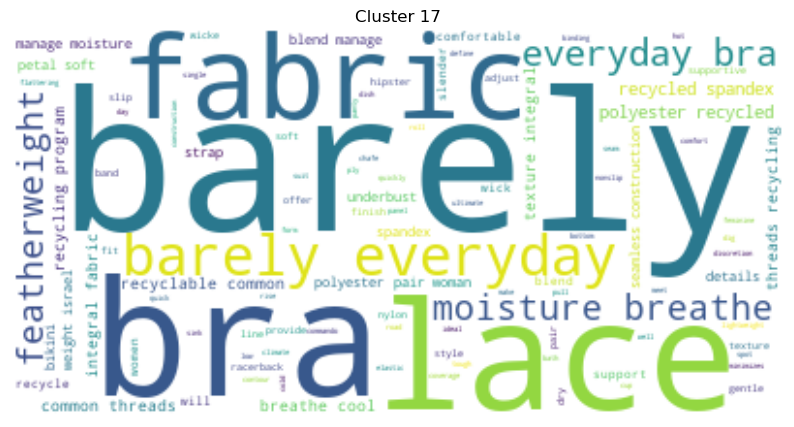

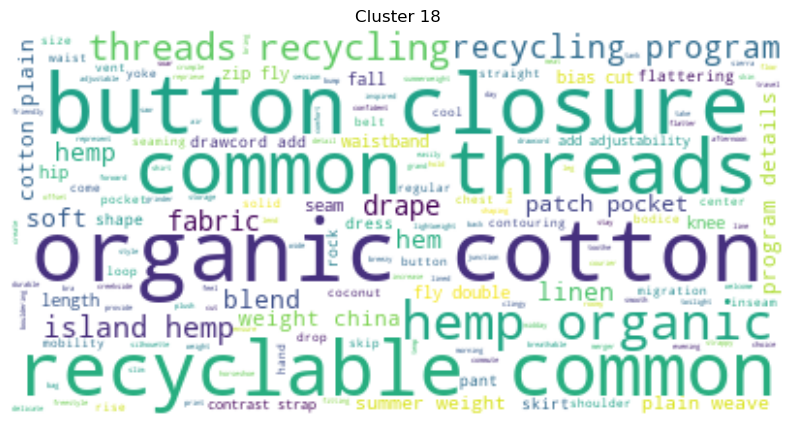

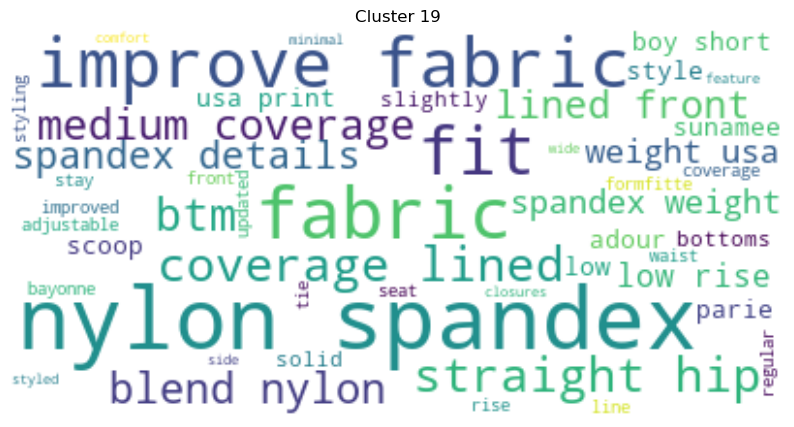

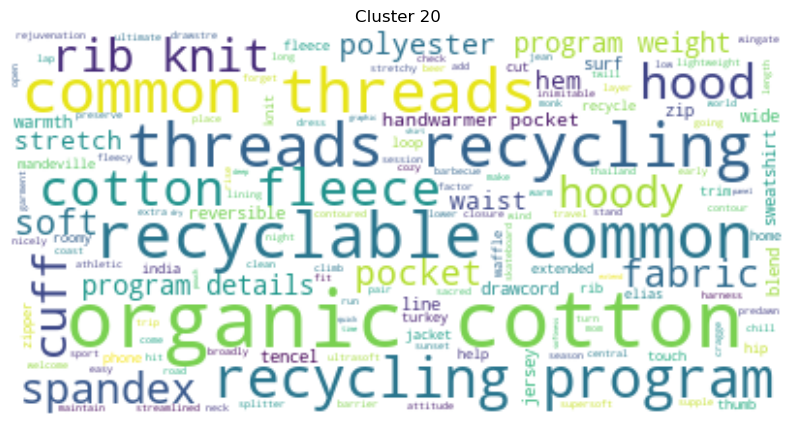

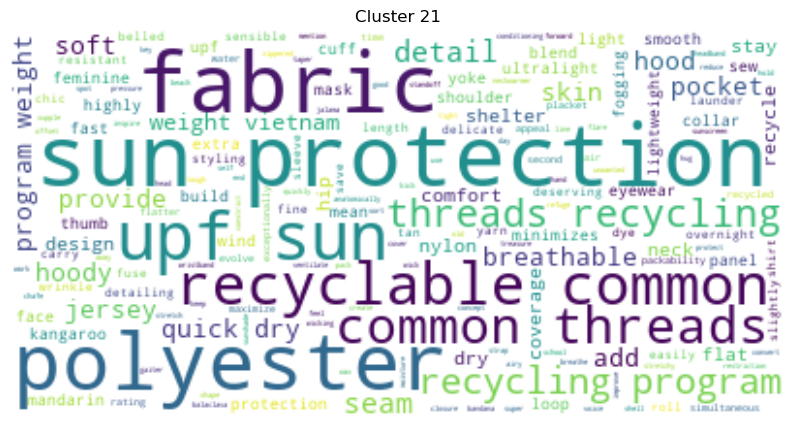

In [16]:
# Generate and display word clouds for each cluster
for cluster in set(clusters):
    if cluster == -1:
        continue  # Skip outliers
    cluster_texts = df[df['cluster'] == cluster]['cleaned_description'].values
    text = " ".join(cluster_texts)
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


# Save DF

In [17]:
df.head()

id                                cleaned_description  cluster
0   1  active classic boxer reason boxer cult favorit...        0
1   2  active sport boxer brief skin glory require mo...       -1
2   3  active sport brief superbreathable fly brief m...       -1
3   4  alpine guide pant skin climb ice switch rock t...        1
4   5  alpine wind jkt high ridge steep ice alpine ja...        1

In [18]:
df.to_csv('/Users/antoinebertin/Documents/jedha/full_stack/projects_full_stack/north_face/df.csv', index=False)